# MNIST Classification and Neural Network Modelling

## Libraries and Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import idx2numpy
import time

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix

## Data Preprocessing

### MNIST Dataset Loading

In [2]:
X_train = './dataset/train-images.idx3-ubyte'
Y_train = './dataset/train-labels.idx1-ubyte'

### Converting IDX binary files to NumPy arrays

In [3]:
X_train = idx2numpy.convert_from_file(X_train)
Y_train = idx2numpy.convert_from_file(Y_train)

### Flattening Images

In [4]:
X_train = X_train.reshape(-1, 28 * 28)

### Data Normalisation

In [5]:
X_train = X_train / 255.0

## Data Preparation

### Dataset Splitting
#### 60% training, 20% validation, and 20% testing

In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_temp, X_test, Y_temp, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42)

### Batching the Data

In [7]:
training_dataset = TensorDataset(X_train, Y_train)
validation_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

def data_loader(batch_size):
    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = data_loader(64)

## Softmax Regression

### Model Implementation

In [8]:
class SoftmaxRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

### Optimizer and Loss Function Definition

In [9]:
def softmax(learning_rate, weight_decay=0.0):
    model = SoftmaxRegression(input_size=28*28, num_classes=10)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion

model, optimizer, criterion = softmax(0.01)

### Training and Logging

In [10]:
def trainer(model, optimizer, criterion, train_loader, val_loader, epochs):
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    training_times = []
    validation_times = []

    for epoch in range(epochs):
        model.train()
        epoch_training_loss = 0
        correct_train = 0
        total_train = 0
        start_training_time = time.time()

        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_training_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        training_time = time.time() - start_training_time
        training_times.append(training_time)
        training_losses.append(epoch_training_loss / len(train_loader))
        training_accuracies.append(correct_train / total_train)

        # Validation Phase
        model.eval()
        epoch_validation_loss = 0
        correct_val = 0
        total_val = 0
        start_validation_time = time.time()

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)

                epoch_validation_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        validation_time = time.time() - start_validation_time
        validation_times.append(validation_time)
        validation_losses.append(epoch_validation_loss / len(val_loader))
        validation_accuracies.append(correct_val / total_val)

    return training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times

training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)

### Testing

In [11]:
def tester(model, test_loader):
    model.eval()

    true_labels = []
    predicted_labels = []

    total = 0
    correct = 0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.numpy())
            predicted_labels.extend(preds.numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total

    return true_labels, predicted_labels, accuracy

true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

### Visualisation and Plotting

In [12]:
def plotter(training_losses, validation_losses, train_label, val_label):
    plt.plot(training_losses, label=train_label)
    plt.plot(validation_losses, label=val_label)
    plt.legend()
    plt.show()

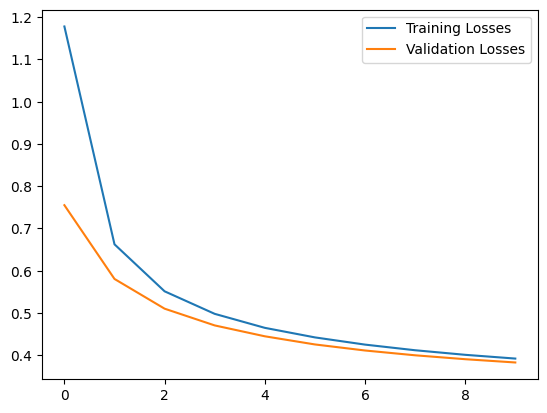

In [13]:
plotter(training_losses, validation_losses, 'Training Losses', 'Validation Losses')

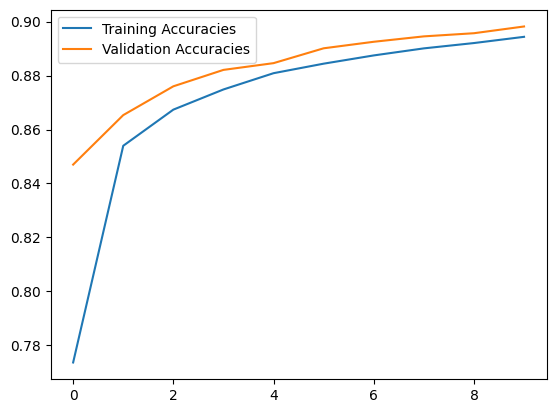

In [14]:
plotter(training_accuracies, validation_accuracies, 'Training Accuracies', 'Validation Accuracies')

### Performance Analysis

#### Generating a Confusion Matrix

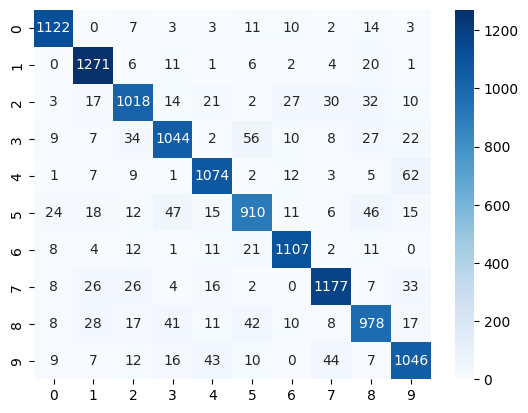

Accuracy 0.8955833333333333


In [15]:
def confusion_matrix_generator(true_labels, predicted_labels):
    confusion = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.show()

confusion_matrix_generator(true_labels, predicted_labels)
print("Accuracy", test_accuracy)

### Parameter Analysis

#### Changing Learning Rates

-------------------- Learning Rate: 0.001 --------------------


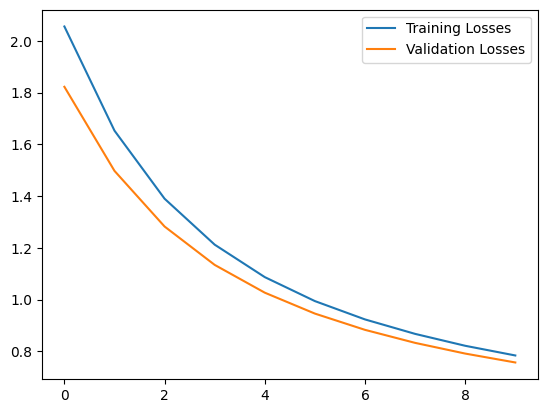

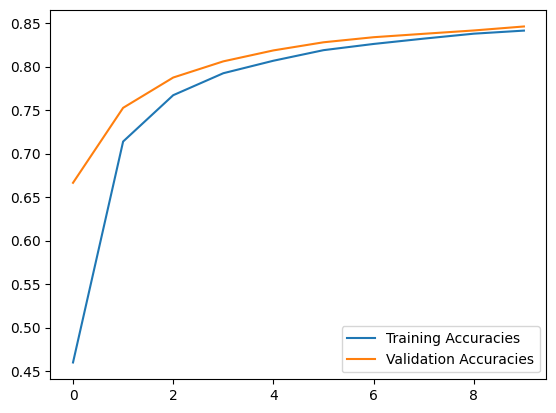

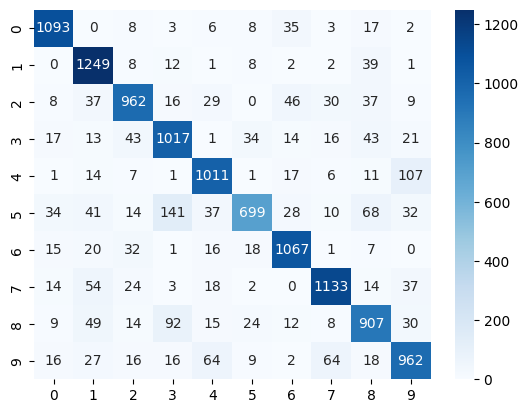

Traning time: 7.215921401977539
Validation time: 1.4296011924743652
Test Accuracy 0.8416666666666667
training_losses: [2.0560032427840294, 1.6530477016052598, 1.3898465048991553, 1.2121571015507036, 1.086615743476163, 0.9939319550673449, 0.9230218226913872, 0.8671170864816669, 0.8210842105465714, 0.7836107246405701]

validation_losses: [1.8226972773988197, 1.4975115637829963, 1.2822929430515209, 1.133876253315743, 1.0264580474889025, 0.9455925223041088, 0.8826932339592183, 0.8323426237131687, 0.7909506451576314, 0.7565099251397113]

training_accuracies: [0.4598333333333333, 0.7137777777777777, 0.7670277777777778, 0.7922777777777777, 0.8066388888888889, 0.8187777777777778, 0.8259166666666666, 0.8320277777777778, 0.8377222222222223, 0.84125]

validation_accuracies: [0.6663333333333333, 0.7525, 0.7873333333333333, 0.8059166666666666, 0.8185, 0.8278333333333333, 0.8336666666666667, 0.8375833333333333, 0.8414166666666667, 0.846]
-------------------- Learning Rate: 0.01 --------------------


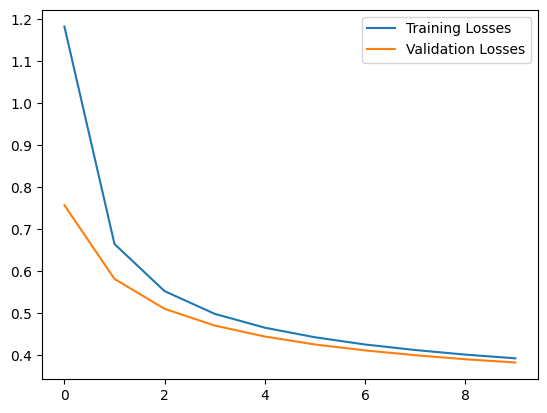

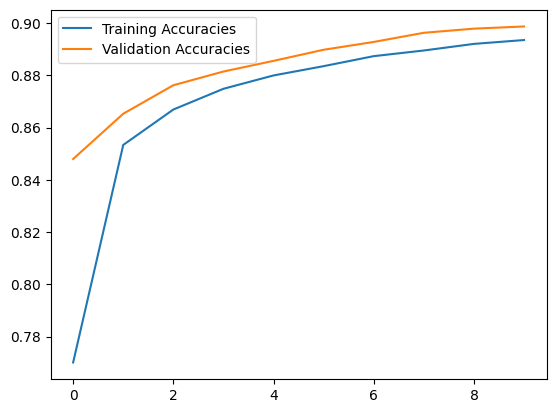

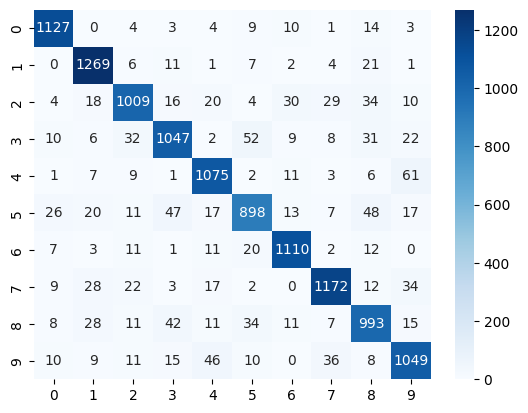

Traning time: 7.690215587615967
Validation time: 1.5421690940856934
Test Accuracy 0.89575
training_losses: [1.182477285764569, 0.6645860507899025, 0.552432870197889, 0.4984704374102462, 0.4654572084678426, 0.44269402936550906, 0.42545882253833184, 0.4123304202543906, 0.40135116112909774, 0.39257966161938795]

validation_losses: [0.7571556923237253, 0.581451563759053, 0.5103797752489435, 0.4705008220799426, 0.4444274805644725, 0.4255172796547413, 0.41143441461819286, 0.3999352678656578, 0.39030228626537833, 0.38263644333532515]

training_accuracies: [0.7700833333333333, 0.8533888888888889, 0.8669444444444444, 0.8748888888888889, 0.88, 0.8835555555555555, 0.8873888888888889, 0.8895555555555555, 0.8920833333333333, 0.8935555555555555]

validation_accuracies: [0.848, 0.8653333333333333, 0.87625, 0.8815, 0.8855833333333333, 0.8898333333333334, 0.8928333333333334, 0.8963333333333333, 0.8979166666666667, 0.89875]
-------------------- Learning Rate: 0.1 --------------------


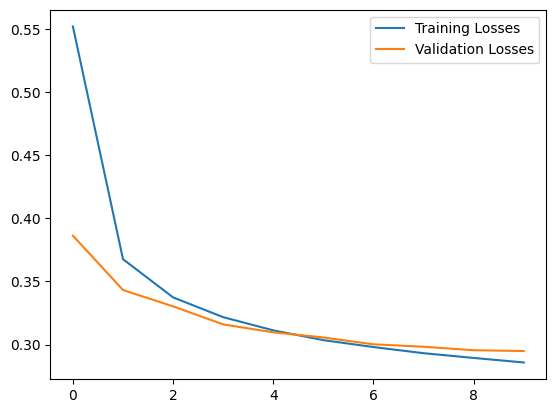

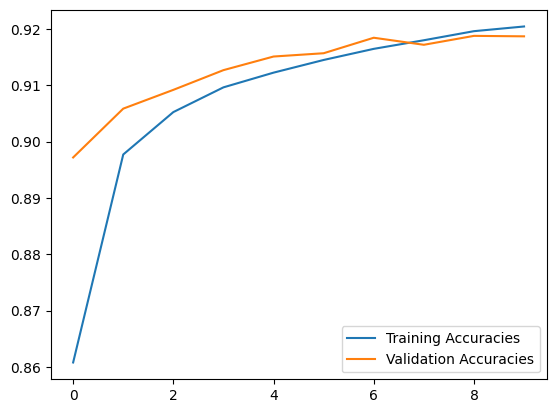

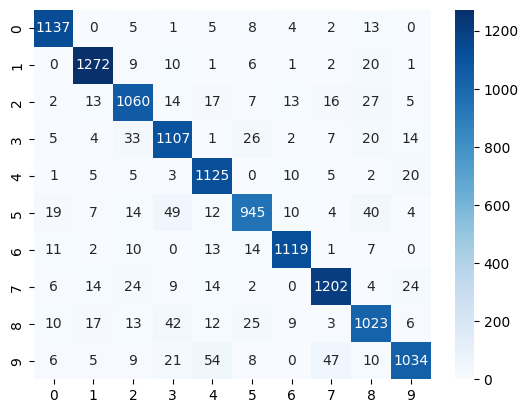

Traning time: 7.043020009994507
Validation time: 1.5107660293579102
Test Accuracy 0.9186666666666666
training_losses: [0.5519097833555079, 0.3676185107675793, 0.3373393789463103, 0.32168207091294215, 0.3112491625055115, 0.30347329528992384, 0.2980077719021436, 0.29314619177029355, 0.28938795787614785, 0.28579672621182606]

validation_losses: [0.38625686496813244, 0.3431856992872471, 0.3302452258686436, 0.31596103100542056, 0.309670362740438, 0.30560747716338077, 0.300169207552012, 0.2982653123029369, 0.29550359616095717, 0.29485535098517196]

training_accuracies: [0.8607777777777778, 0.8976944444444445, 0.9052222222222223, 0.9096111111111111, 0.9122222222222223, 0.9144722222222222, 0.9164444444444444, 0.9179722222222222, 0.9195833333333333, 0.9204166666666667]

validation_accuracies: [0.8971666666666667, 0.9058333333333334, 0.9091666666666667, 0.9126666666666666, 0.9150833333333334, 0.9156666666666666, 0.9184166666666667, 0.9171666666666667, 0.91875, 0.9186666666666666]
---------------

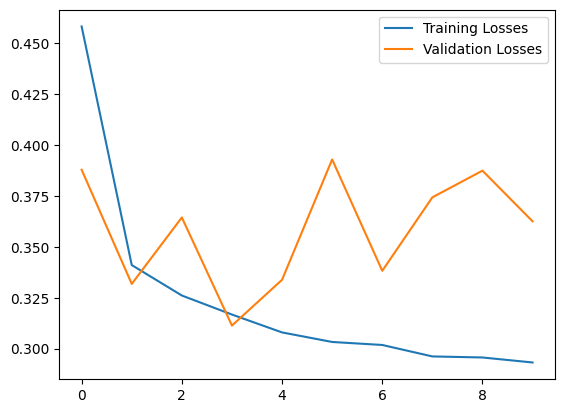

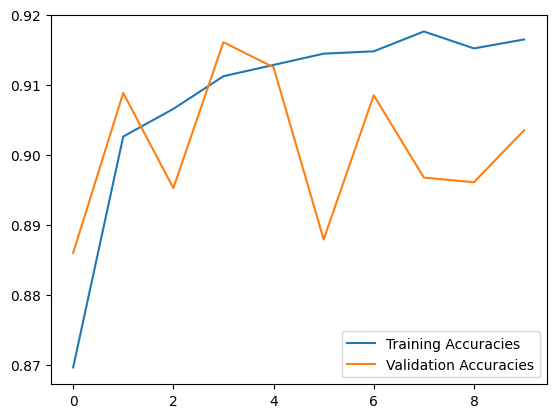

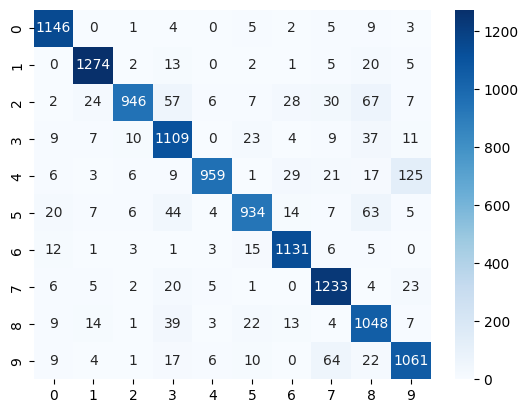

Traning time: 7.2359092235565186
Validation time: 1.3938510417938232
Test Accuracy 0.9034166666666666
training_losses: [0.4581528778186276, 0.3410428640156402, 0.3260920017653312, 0.3167471960716307, 0.3079761014804641, 0.30328951842196245, 0.30181388629080985, 0.296188700447921, 0.295673428391161, 0.29322074053289626]

validation_losses: [0.38782243375131426, 0.33179278651926114, 0.36440865531008926, 0.3113360502063594, 0.33380712360698495, 0.3928704832660708, 0.3382231314924169, 0.37427612191977655, 0.38737943740759756, 0.36251810712224625]

training_accuracies: [0.8696388888888889, 0.9026111111111111, 0.9065555555555556, 0.9112222222222223, 0.9128333333333334, 0.9144444444444444, 0.9147777777777778, 0.9176111111111112, 0.9151944444444444, 0.9164722222222222]

validation_accuracies: [0.886, 0.9088333333333334, 0.89525, 0.9160833333333334, 0.9125, 0.8879166666666667, 0.9085, 0.89675, 0.8960833333333333, 0.9035]


In [16]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
for lr in learning_rates:
    train_loader, val_loader, test_loader = data_loader(64)
    model, optimizer, criterion = softmax(lr)
    training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
    true_labels, predicted_labels, test_accuracy = tester(model, test_loader)
    print(f"-------------------- Learning Rate: {lr} --------------------")
    plotter(training_losses, validation_losses,  'Training Losses', 'Validation Losses')
    plotter(training_accuracies, validation_accuracies,  'Training Accuracies', 'Validation Accuracies')
    confusion_matrix_generator(true_labels, predicted_labels)
    print("Traning time:", sum(training_times))
    print("Validation time:", sum(validation_times))
    print('Test Accuracy', test_accuracy)

    print("training_losses:", training_losses)
    print()
    print("validation_losses:", validation_losses)
    print()
    print("training_accuracies:", training_accuracies)
    print()
    print("validation_accuracies:", validation_accuracies)

#### Changing Batch Sizes

-------------------- Batch Size: 32 --------------------


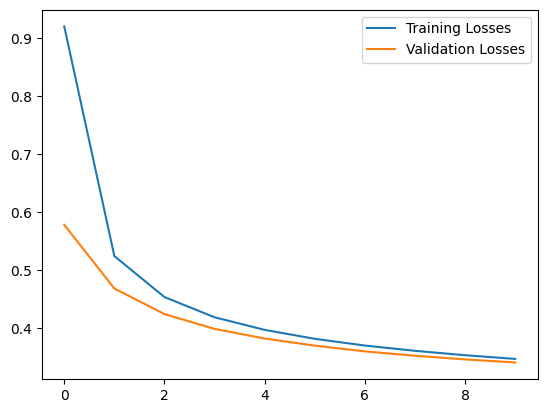

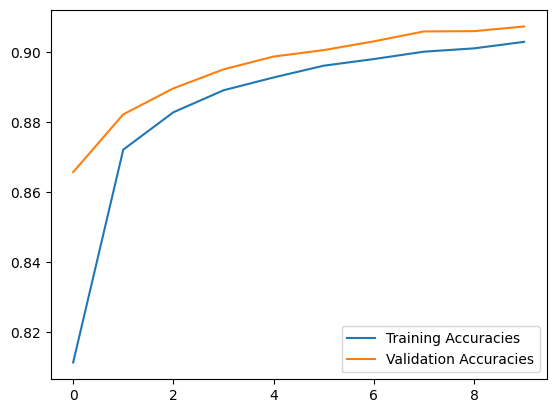

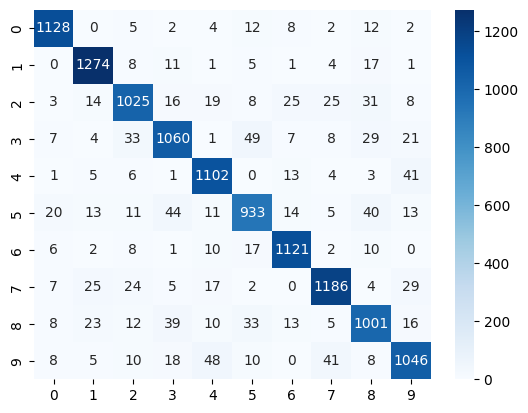

Traning time: 10.39124083518982
Validation time: 1.8547072410583496
Test Accuracy 0.9063333333333333
training_losses: [0.9204894085990059, 0.5239717386298709, 0.4532039405902227, 0.41831205908457436, 0.3965671303404702, 0.3811312424606747, 0.3694805279506577, 0.36038569716612495, 0.352786554131243, 0.34644853185282815]

validation_losses: [0.5778925596872966, 0.46804048216342925, 0.4238437472184499, 0.39821459766228995, 0.3816087154150009, 0.3693718149463336, 0.3594197927117348, 0.3519086703459422, 0.345533941924572, 0.3402540546456973]

training_accuracies: [0.8113333333333334, 0.8720833333333333, 0.88275, 0.8890277777777778, 0.8926944444444445, 0.8960555555555556, 0.8979444444444444, 0.9000555555555556, 0.901, 0.9028611111111111]

validation_accuracies: [0.8656666666666667, 0.8821666666666667, 0.8895833333333333, 0.895, 0.8986666666666666, 0.9005, 0.903, 0.9058333333333334, 0.9059166666666667, 0.90725]
-------------------- Batch Size: 64 --------------------


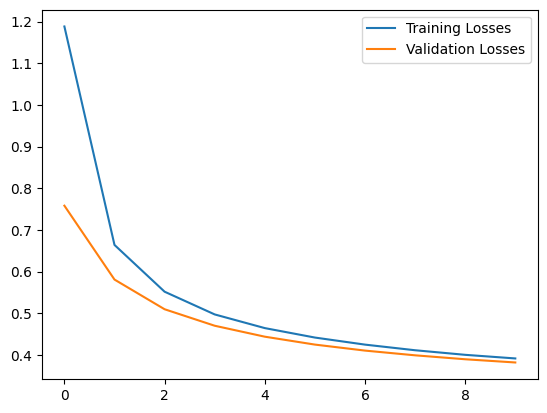

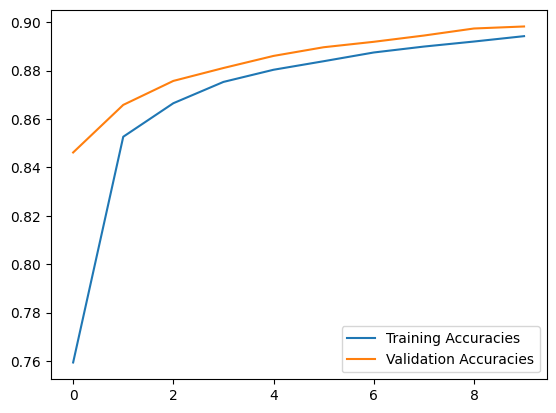

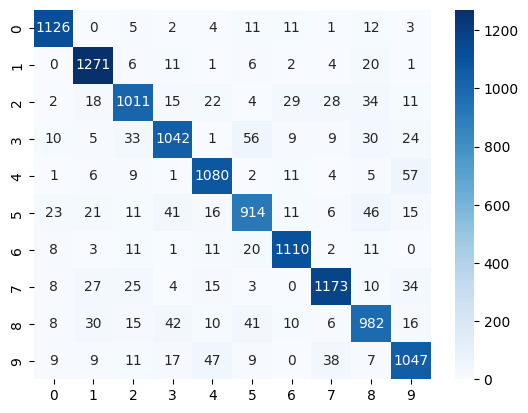

Traning time: 6.274890661239624
Validation time: 1.3471291065216064
Test Accuracy 0.8963333333333333
training_losses: [1.1883231170647521, 0.6640854448238868, 0.5518225903621152, 0.4972776262946493, 0.4644744046310337, 0.4417893258758802, 0.4248285300725307, 0.4113204796826649, 0.4003232138936092, 0.391656168030168]

validation_losses: [0.7582396319571961, 0.5809504223313737, 0.5097187147178548, 0.47013671513884625, 0.4438684705565584, 0.4248982517326132, 0.41048026251349046, 0.3991438908938398, 0.3896802282555306, 0.3819655350389633]

training_accuracies: [0.7593611111111112, 0.8526666666666667, 0.8665277777777778, 0.8753333333333333, 0.8803611111111111, 0.8838888888888888, 0.8875, 0.8899444444444444, 0.8920277777777778, 0.89425]

validation_accuracies: [0.8461666666666666, 0.8658333333333333, 0.87575, 0.8810833333333333, 0.8860833333333333, 0.8896666666666667, 0.8919166666666667, 0.8945, 0.8974166666666666, 0.89825]
-------------------- Batch Size: 128 --------------------


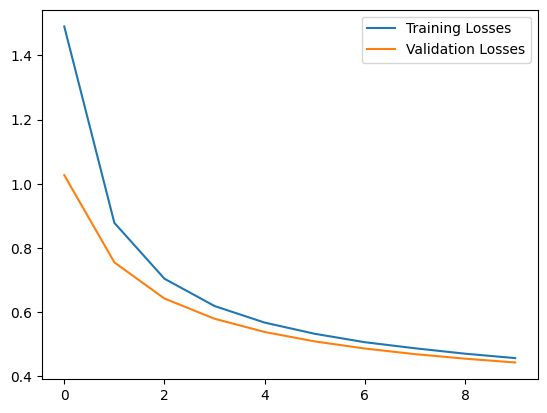

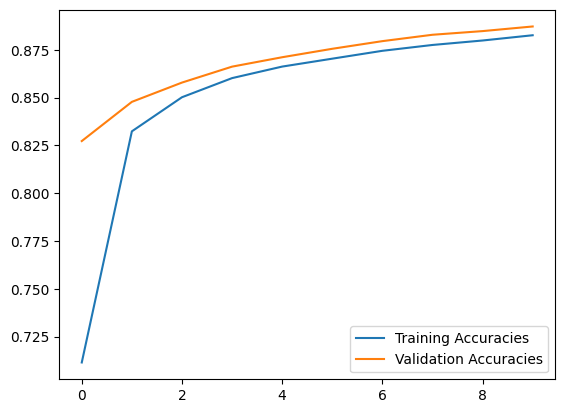

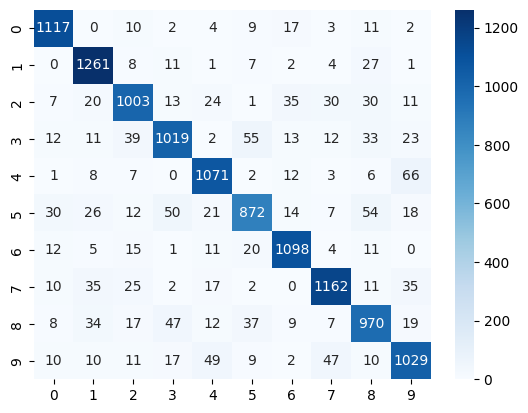

Traning time: 3.8787519931793213
Validation time: 0.910261869430542
Test Accuracy 0.8835
training_losses: [1.4898965212892978, 0.8780261417652698, 0.7039810968629012, 0.618914802129387, 0.5673241000226203, 0.532417893198365, 0.5061940115394322, 0.48731621634875627, 0.4704439042941898, 0.4566832206984784]

validation_losses: [1.0266947048775694, 0.7549590214769891, 0.6423013162739734, 0.5793351711744957, 0.5380895182173303, 0.508686494637043, 0.4865153802836195, 0.46907918282011724, 0.45495325739079334, 0.44306053094407344]

training_accuracies: [0.7114722222222222, 0.8323333333333334, 0.8501666666666666, 0.8601666666666666, 0.8661944444444445, 0.8703333333333333, 0.8744444444444445, 0.8775, 0.8798333333333334, 0.8825833333333334]

validation_accuracies: [0.82725, 0.84775, 0.8578333333333333, 0.8661666666666666, 0.8710833333333333, 0.8755, 0.8795, 0.8828333333333334, 0.88475, 0.8871666666666667]
-------------------- Batch Size: 256 --------------------


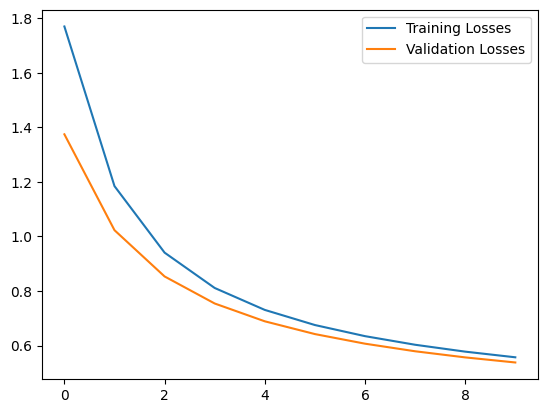

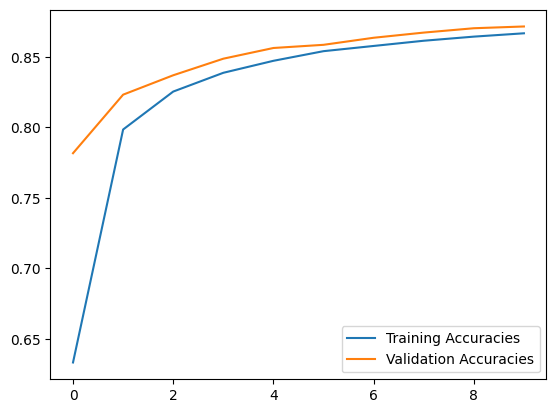

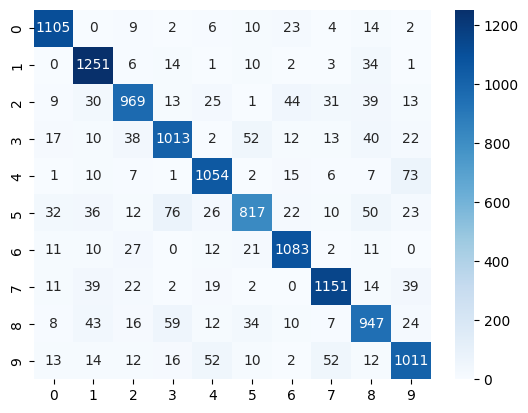

Traning time: 3.100698232650757
Validation time: 0.8659718036651611
Test Accuracy 0.86675
training_losses: [1.7703480416155877, 1.1847565182557342, 0.940755084896764, 0.8111147149234799, 0.7306764341415243, 0.6752245324723264, 0.6344398450344166, 0.6028794798445194, 0.5776125714711263, 0.5568684098568368]

validation_losses: [1.374792662072689, 1.023088609918635, 0.853413239438483, 0.7542013285007882, 0.6888605533762181, 0.6420598537363904, 0.6068060778556986, 0.5789880980836585, 0.5565022610603495, 0.5378613852440043]

training_accuracies: [0.6333333333333333, 0.7984722222222222, 0.8253611111111111, 0.8386666666666667, 0.8471666666666666, 0.854, 0.8576944444444444, 0.8613888888888889, 0.8643055555555555, 0.8666666666666667]

validation_accuracies: [0.7816666666666666, 0.8231666666666667, 0.8369166666666666, 0.8486666666666667, 0.85625, 0.8585, 0.8635, 0.8671666666666666, 0.87025, 0.8715]


In [17]:
batch_sizes = [32, 64, 128, 256]
for b in batch_sizes:
    train_loader, val_loader, test_loader = data_loader(b)
    model, optimizer, criterion = softmax(0.01)
    training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
    true_labels, predicted_labels, test_accuracy = tester(model, test_loader)
    print(f"-------------------- Batch Size: {b} --------------------")
    plotter(training_losses, validation_losses, 'Training Losses', 'Validation Losses')
    plotter(training_accuracies, validation_accuracies, 'Training Accuracies', 'Validation Accuracies')
    confusion_matrix_generator(true_labels, predicted_labels)
    print("Traning time:", sum(training_times))
    print("Validation time:", sum(validation_times))
    print('Test Accuracy', test_accuracy)

    print("training_losses:", training_losses)
    print()
    print("validation_losses:", validation_losses)
    print()
    print("training_accuracies:", training_accuracies)
    print()
    print("validation_accuracies:", validation_accuracies)

#### Adding L2 Regularisation

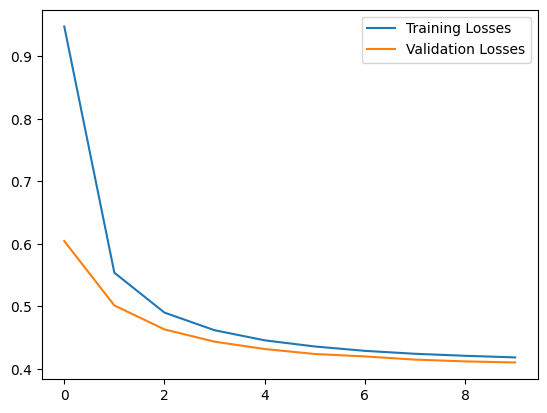

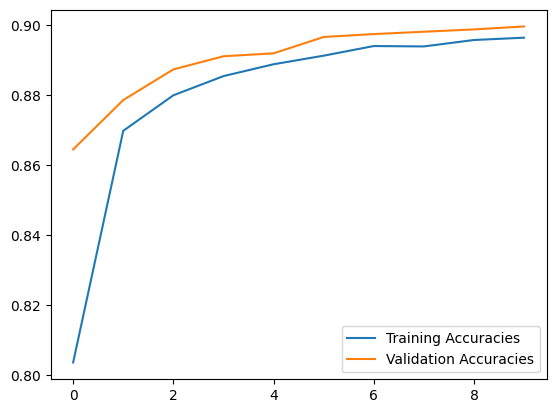

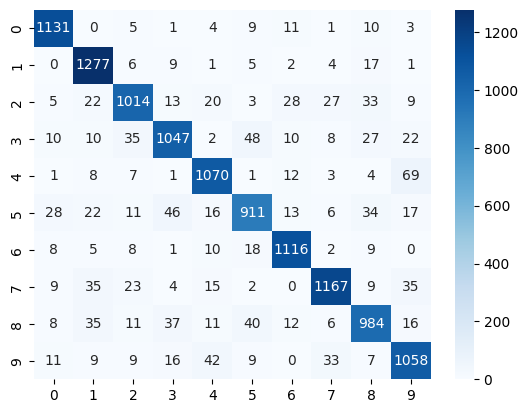

Traning time: 9.58513879776001
Validation time: 1.6768758296966553
Test Accuracy 0.8979166666666667
training_losses: [0.947396396530999, 0.5539084662993748, 0.49020081876383886, 0.4620265642934375, 0.4458804759118292, 0.436047926041815, 0.4290825388431549, 0.42437640509340496, 0.4211883803076214, 0.41858450310760076]

validation_losses: [0.6044785415331523, 0.5016110004583995, 0.46333295063177743, 0.44371255973974866, 0.43200943342844644, 0.4240391358931859, 0.42016306376457213, 0.41506403481960297, 0.4122270128726959, 0.4104846374988556]

training_accuracies: [0.8036944444444445, 0.8698055555555556, 0.8799444444444444, 0.8854166666666666, 0.8888055555555555, 0.89125, 0.894, 0.8938888888888888, 0.8957222222222222, 0.8963888888888889]

validation_accuracies: [0.8645, 0.8785833333333334, 0.8873333333333333, 0.8910833333333333, 0.8919166666666667, 0.8965833333333333, 0.8974166666666666, 0.8980833333333333, 0.89875, 0.8995833333333333]


In [18]:
train_loader, val_loader, test_loader = data_loader(32)

model, optimizer, criterion = softmax(0.01, weight_decay=0.01)

training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)


true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

plotter(training_losses, validation_losses, 'Training Losses', 'Validation Losses')

plotter(training_accuracies, validation_accuracies, 'Training Accuracies', 'Validation Accuracies')

confusion_matrix_generator(true_labels, predicted_labels)

print("Traning time:", sum(training_times))
print("Validation time:", sum(validation_times))
print("Test Accuracy", test_accuracy)

print("training_losses:", training_losses)
print()
print("validation_losses:", validation_losses)
print()
print("training_accuracies:", training_accuracies)
print()
print("validation_accuracies:", validation_accuracies)

### Neural Network Modelling

### Model Implementation

In [19]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### Training and Logging

In [20]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = 10

def neural_network(input_size, hidden_size, output_size, learning_rate, weight_decay=0.0):
    model = FeedforwardNN(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    return model, optimizer, criterion

model, optimizer, criterion = neural_network(input_size, hidden_size, output_size, 0.01)

In [21]:
training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)

true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

print("Traning time:", sum(training_times))
print("Validation time:", sum(validation_times))
print('Test Accuracy', test_accuracy)
print("training_losses:", training_losses)
print()
print("validation_losses:", validation_losses)
print()
print("training_accuracies:", training_accuracies)
print()
print("validation_accuracies:", validation_accuracies)

Traning time: 30.616519927978516
Validation time: 2.088838815689087
Test Accuracy 0.9543333333333334
training_losses: [0.27865400345706276, 0.16924975088725072, 0.14546660117282428, 0.12899833128111074, 0.12042926186744202, 0.11526071377230497, 0.11492407108270951, 0.09154322700980497, 0.09601717327944506, 0.09771616208963102]

validation_losses: [0.20243706735099357, 0.17977277018285046, 0.19211575102309386, 0.2046828105870518, 0.2080073114912957, 0.28912857665024544, 0.26893105357922953, 0.3113255120596732, 0.2550379502659571, 0.28716667598796386]

training_accuracies: [0.9152222222222223, 0.9520833333333333, 0.9593888888888888, 0.9642777777777778, 0.9679444444444445, 0.9697777777777777, 0.9705, 0.9771944444444445, 0.9759166666666667, 0.9768055555555556]

validation_accuracies: [0.94175, 0.9549166666666666, 0.9553333333333334, 0.95625, 0.9565, 0.94775, 0.9596666666666667, 0.9519166666666666, 0.9608333333333333, 0.959]


### Visualisation and Plotting

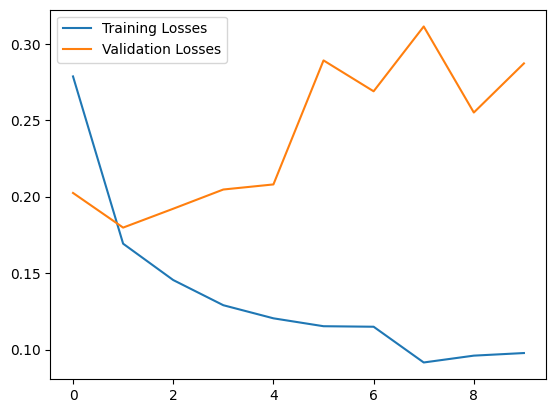

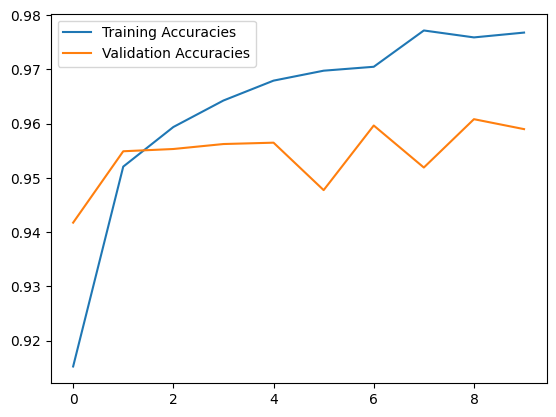

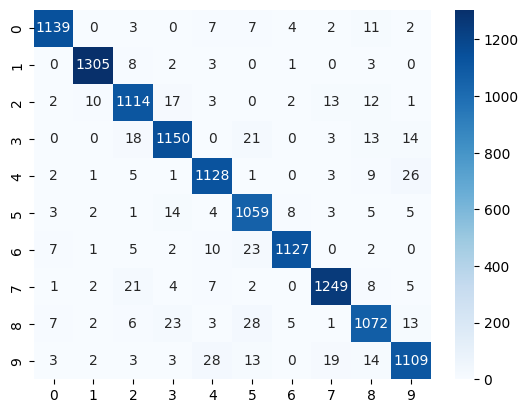

Test Accuracy 0.9543333333333334
training_losses: [0.27865400345706276, 0.16924975088725072, 0.14546660117282428, 0.12899833128111074, 0.12042926186744202, 0.11526071377230497, 0.11492407108270951, 0.09154322700980497, 0.09601717327944506, 0.09771616208963102]

validation_losses: [0.20243706735099357, 0.17977277018285046, 0.19211575102309386, 0.2046828105870518, 0.2080073114912957, 0.28912857665024544, 0.26893105357922953, 0.3113255120596732, 0.2550379502659571, 0.28716667598796386]

training_accuracies: [0.9152222222222223, 0.9520833333333333, 0.9593888888888888, 0.9642777777777778, 0.9679444444444445, 0.9697777777777777, 0.9705, 0.9771944444444445, 0.9759166666666667, 0.9768055555555556]

validation_accuracies: [0.94175, 0.9549166666666666, 0.9553333333333334, 0.95625, 0.9565, 0.94775, 0.9596666666666667, 0.9519166666666666, 0.9608333333333333, 0.959]


In [22]:
plotter(training_losses, validation_losses, 'Training Losses', 'Validation Losses')

plotter(training_accuracies, validation_accuracies, 'Training Accuracies', 'Validation Accuracies')

confusion_matrix_generator(true_labels, predicted_labels)
print("Test Accuracy", test_accuracy)

print("training_losses:", training_losses)
print()
print("validation_losses:", validation_losses)
print()
print("training_accuracies:", training_accuracies)
print()
print("validation_accuracies:", validation_accuracies)

## Analysis and Comparison

### Metrics for Comparison
1. **Final Test Accuracy**: The percentage of correctly classified images from the test dataset.
2. **Training Time**: The total time taken to train each model across all epochs.

- Best test accuracy using **SoftmaxRegression** was with `batch size = 64` and `learning rate = 0.1`. The **Test Accuracy = 0.9190833333333334**. Training Time: 8.9 sec. Validation Time: 1.87 sec.


- Using **Neural Network** with `batch size = 32` and `learning rate = 0.001`. We reached `Test Accuracy 0.9739166666666667`.  Training Time: 47.41 sec. Validation Time: 3.88 sec.

In [23]:
def softmax_data_generator(batch_sizes, learning_rates):
    softmax_data_no_regularisation = []
    softmax_data_regularisation = []

    for b in batch_sizes:
        for lr in learning_rates:

            # -------------------------- [without L2 regularisation] --------------------------

            train_loader, val_loader, test_loader = data_loader(b)
            model, optimizer, criterion = softmax(lr)
            training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
            true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

            temp = [sum(training_times), sum(validation_times), validation_accuracies[-1], test_accuracy]
            softmax_data_no_regularisation.append(temp)

            # ---------------------------- [with L2 regularisation] ----------------------------

            train_loader, val_loader, test_loader = data_loader(b)
            model, optimizer, criterion = softmax(lr, weight_decay=0.01)
            training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
            true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

            temp = [sum(training_times), sum(validation_times), validation_accuracies[-1], test_accuracy]
            softmax_data_regularisation.append(temp)

    return softmax_data_no_regularisation, softmax_data_regularisation

In [24]:
def nn_data_generator(input_size, hidden_size, output_size, batch_sizes, learning_rates):
    nn_data_no_regularisation = []
    nn_data_regularisation = []
    for b in batch_sizes:
        for lr in learning_rates:

            # -------------------------- [without L2 regularisation] --------------------------

            train_loader, val_loader, test_loader = data_loader(b)
            model, optimizer, criterion = neural_network(input_size, hidden_size, output_size, lr)
            training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
            true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

            temp = [sum(training_times), sum(validation_times), validation_accuracies[-1], test_accuracy]
            nn_data_no_regularisation.append(temp)

            # ---------------------------- [with L2 regularisation] ----------------------------

            train_loader, val_loader, test_loader = data_loader(b)
            model, optimizer, criterion = neural_network(input_size, hidden_size, output_size, lr, weight_decay=0.01)
            training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
            true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

            temp = [sum(training_times), sum(validation_times), validation_accuracies[-1], test_accuracy]
            nn_data_regularisation.append(temp)
    return nn_data_no_regularisation, nn_data_regularisation

In [25]:
def dataframe_generator(columns, batch_sizes, learning_rates, data_no_regularisation, data_regularisation):
    no_reg_data = [
        [b, lr, "No", *data_no_regularisation[i]]
        for i, (b, lr) in enumerate((b, lr) for b in batch_sizes for lr in learning_rates)
    ]

    reg_data = [
        [b, lr, "Yes", *data_regularisation[i]]
        for i, (b, lr) in enumerate((b, lr) for b in batch_sizes for lr in learning_rates)
    ]

    data = no_reg_data + reg_data
    df = pd.DataFrame(data, columns=columns)

    return df

In [26]:
columns = ["Batch Size", "Learning Rate", "Regularization", "Training Time", "Validation Time", "Validation Accuracy", "Test Accuracy"]

batch_sizes = [32, 64, 128, 256]
learning_rates = [0.001, 0.01, 0.1, 1.0]

input_size = X_train.shape[1]
hidden_size = 128
output_size = 10

softmax_data_no_regularisation, softmax_data_regularisation = softmax_data_generator(batch_sizes, learning_rates)
softmax_df = dataframe_generator(columns, batch_sizes, learning_rates, softmax_data_no_regularisation, softmax_data_regularisation)

nn_data_no_regularisation, nn_data_regularisation = nn_data_generator(input_size, hidden_size, output_size, batch_sizes, learning_rates)
nn_df = dataframe_generator(columns, batch_sizes, learning_rates, nn_data_no_regularisation, nn_data_regularisation)


In [27]:
softmax_df

,Batch Size,Learning Rate,Regularization,Training Time,Validation Time,Validation Accuracy,Test Accuracy
0,32,0.001,No,11.970790,2.118804,0.866083,0.861250
1,32,0.010,No,11.016639,2.006012,0.906917,0.905250
2,32,0.100,No,11.527780,2.266402,0.919583,0.920167
3,32,1.000,No,10.744712,1.910052,0.880750,0.875583
4,64,0.001,No,6.347309,1.404014,0.847167,0.838917
5,64,0.010,No,5.929550,1.248466,0.898000,0.895500
6,64,0.100,No,6.354043,1.443549,0.919667,0.918583
7,64,1.000,No,5.677582,1.226526,0.896833,0.894417
8,128,0.001,No,4.174688,1.017976,0.825333,0.814750
9,128,0.010,No,3.859220,0.948523,0.885917,0.882917


In [28]:
nn_df

,Batch Size,Learning Rate,Regularization,Training Time,Validation Time,Validation Accuracy,Test Accuracy
0,32,0.001,No,20.481364,1.765152,0.972917,0.974583
1,32,0.010,No,28.303874,1.882041,0.964417,0.963083
2,32,0.100,No,34.812692,1.944909,0.359333,0.363583
3,32,1.000,No,37.369679,1.713209,0.097917,0.098083
4,64,0.001,No,11.090237,1.349956,0.973000,0.971500
5,64,0.010,No,14.394027,1.443001,0.965667,0.962833
6,64,0.100,No,22.107260,1.614276,0.661583,0.668583
7,64,1.000,No,25.994314,1.650558,0.106833,0.102833
8,128,0.001,No,7.222749,1.098831,0.970500,0.969750
9,128,0.010,No,8.503206,1.188966,0.968500,0.966917
